In [1]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque

from torchvision import transforms as T

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [2]:
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)
        # self.coin_reward = 10
        self.previous_coins = 0
        self.previous_score = 0

    def step(self, action):
        state, reward, done, info = self.env.step(action)

        # if info['coins'] > self.previous_coins:
        #     reward += self.coin_reward

        # Check for score changes
        reward += (info['score'] - self.previous_score) / 50.0

        # Update previous values
        # self.previous_coins = info['coins']
        self.previous_score = info['score']

        return state, reward, done, info

    def reset(self, **kwargs):
        # self.previous_coins = 0
        self.previous_score = 0
        return self.env.reset(**kwargs)

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = CustomRewardWrapper(env)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\dan2972\miniconda3\envs\cs175\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [3]:
# Load model
model = PPO.load('./train_10/best_model_4000000')

In [4]:
def record_video(env, model, out_directory, fps=30, max_frames = 10000):
  images = []
  done = False
  state = env.reset()
  frame_counter = 0
  while not done and frame_counter < max_frames:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    img = env.render('rgb_array')
    x = img.copy()
    images.append(x)
    frame_counter += 1
  imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)

In [5]:
record_video(env, model, './replay_ppo.mp4', 120)

In [6]:
def get_avg_rewards(env, runs_per_model=3):
    rewards = []
    state = env.reset()

    for model_num in range(1, 401):
        print(f'loading model {model_num*10000}')
        model = PPO.load(f'./train_10/best_model_{model_num*10000}')
        total_reward = 0
        for i in range(runs_per_model):
            while True:
                action, _ = model.predict(state)
                state, reward, done, info = env.step(action)
                total_reward += reward
                if done:
                    break;
            print(f'finished run {i}')
        print(f'finished model {model_num*10000}\t avg reward: {total_reward/runs_per_model}')
        rewards.append(total_reward/runs_per_model)
    return rewards

In [7]:
avg_rewards = get_avg_rewards(env)

loading model 10000
finished run 0
finished run 1
finished run 2
finished model 10000	 avg reward: [139.]
loading model 20000
finished run 0
finished run 1
finished run 2
finished model 20000	 avg reward: [183.]
loading model 30000
finished run 0
finished run 1
finished run 2
finished model 30000	 avg reward: [220.33333]
loading model 40000
finished run 0
finished run 1
finished run 2
finished model 40000	 avg reward: [339.]
loading model 50000
finished run 0
finished run 1
finished run 2
finished model 50000	 avg reward: [249.66667]
loading model 60000
finished run 0
finished run 1
finished run 2
finished model 60000	 avg reward: [279.33334]
loading model 70000
finished run 0
finished run 1
finished run 2
finished model 70000	 avg reward: [141.66667]
loading model 80000
finished run 0
finished run 1
finished run 2
finished model 80000	 avg reward: [272.66666]
loading model 90000
finished run 0
finished run 1
finished run 2
finished model 90000	 avg reward: [220.33333]
loading model 10

Text(0, 0.5, 'Avg Reward')

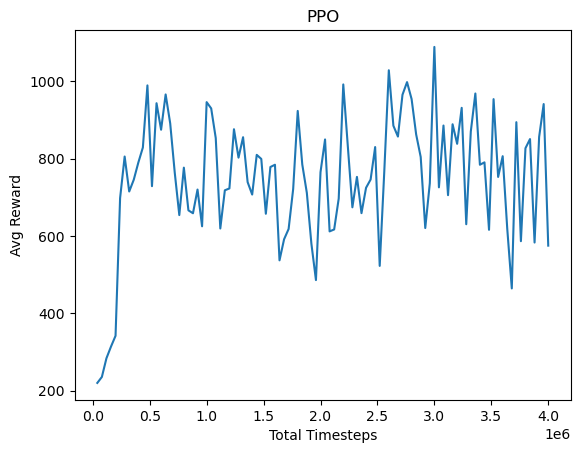

In [3]:
scores = []
with open('text2.txt') as f:
    for line in f:
        if 'avg reward: ' in line:
            i = line.find('avg')
            scores.append(float(line[i+13:-2]))

avg_rewards = np.average(np.array(scores).reshape(-1, 4), axis=1)

x = np.arange(1, len(avg_rewards)+1)
x *= 10000*4
plt.plot(x, avg_rewards)
plt.title("PPO")
plt.xlabel("Total Timesteps")
plt.ylabel("Avg Reward")